# Galaxy Collisions

This module will implinent a simple interactive galaxy collision module. We wil treat the galaxy collision as a restricted threebody problem. Early computer simulatons used the same trick.

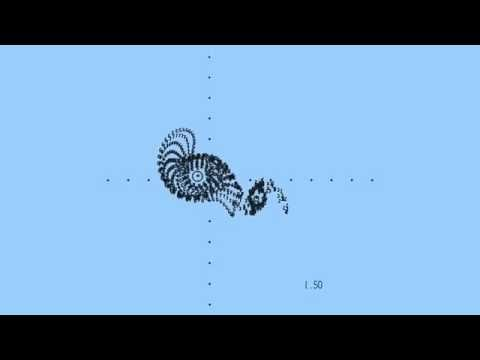

In [217]:
from IPython.display import YouTubeVideo
YouTubeVideo('zvXLWEd2ZGU')

### Imports

In [218]:
#This directory contains all the data needed for the module. It should be in the same directory as the notebook
dataFolder = "data" 
import sys, os, shutil, errno, string, urllib.request, math, copy

sys.path.append(( os.path.abspath( os.path.join(os.path.realpath("__file__"), os.pardir, os.pardir) )))
import uvmodlib.v1 as uvmod

In [219]:
# Run this if you want to build in 3.0 rather than 2.0
from config import Settings
Settings.uvcustommodulelocation='C:\\Users\\msubbarao\\SCISS\\Uniview Theater 3.0\\Custom Modules'

### USES Conf template and Uniform block for gravitating objects

In [220]:
gravsimTemplate =\
"""mesh
{
    glslVersion 400
    cullRadius 100000
    data sphere ./modules/$folderName/sphere.3ds
    data quad  ./modules/$folderName/quad.3ds
    data quad2  ./modules/$folderName/quad.3ds
    data particles ./modules/$folderName/galCollision.uvstream
    
    propertyCollection
    {
        __objectName__
        {
            vec1f gravitationalStrength $gravitationalStrength | public
            vec1f timeStep              $timeStep | public
            vec1f massRatio             1.0 | public |
            vec1f particleSize          $particleSize  | public
            vec3f initialPosition       $initalPosition | public
            vec3f particleColor         $particleColor | public | widget color_rgb
            bool reset                  true | public
            bool frozen                 false | public
            bool corotating             true | public
            vec1f incidentAngle         0. | public | widget slider | range -90 90 | desc "The angle of approach for the second galaxy, a value of 0 is head-on"
            vec1f incomingSpeed         1 | public | desc "The incoming speed of the second galaxy"
            vec1f incomingInclination   0 | public | widget slider | range -90 90 | desc "The inclication of the incoming galaxy"
        }
    }
    
    renderTexture
    {
        name                      dataTexture
        width                     1024
        height                    512
        numTextures               1
        isPingPong                true
        isPersistent              true
        isFramePersistent         true
        internalTextureFormat     GL_RGB32F
        magnify                   GL_NEAREST
        minify                    GL_NEAREST
    }

    pass
    {
        useDataObject quad
        renderTarget
        {
            name dataTexture
            enableColorClear false
        }
        viewIndependent true

        shader
        {
            type defaultMeshShader
            {
                vertexShader     ./modules/$folderName/pass0.vs
                fragmentShader   ./modules/$folderName/pass0.fs
                enable true
                textureFBO dataTexture dataTexture
                stateManagerVar __objectName__.gravitationalStrength gravitationalStrength
                stateManagerVar __objectName__.massRatio  massRatio
             
                stateManagerVar __objectName__.initialPosition        initialPosition
                stateManagerVar __objectName__.timestep        deltat
                stateManagerVar __objectName__.reset        reset
                stateManagerVar __objectName__.frozen        frozen
                stateManagerVar __objectName__.incidentAngle   incidentAngle
                stateManagerVar __objectName__.incomingSpeed   incomingSpeed
                stateManagerVar __objectName__.corotating        isCorotating

                stateManagerVar __objectName__.incomingInclination incomingInclination
                
                texture initTexture ./modules/$folderName/galParticles.png
                {
                    colorspace linear
                }
                
                parameter1i dataTexWidth  1024

                glState
                {
                    UV_BLEND_ENABLE false
                    UV_DEPTH_ENABLE false
                }
            }
        }
    }


    pass
    {
        useDataObject particles
        passEnable false
        shader
        {
            type defaultMeshShader
            {
                vertexShader     ./modules/$folderName/pass1.vs
                fragmentShader   ./modules/$folderName/pass1.fs
                geometryShader   ./modules/$folderName/pass1.gs
                stateManagerVar __objectName__.particleSize particleSize
                stateManagerVar __objectName__.massRatio  massRatio

                textureFBO dataTexture dataTexture
                
                
                stateManagerVar __objectName__.Alpha uv_alpha
                stateManagerVar __objectName__.particleColor particleColor
                stateManagerVar __objectName__.incidentAngle        incidentAngle
                glState
                {
                    UV_CULL_FACE_ENABLE false
                    UV_DEPTH_ENABLE false
                    UV_BLEND_ENABLE true
                    UV_BLEND_FUNC GL_SRC_ALPHA GL_ONE
                }
            }
        }
    }
    
#     pass
#       passEnable true
 #       useDataObject quad2
  #      shader
   #     {
    #       {
     #           fragmentShader   ./modules/$folderName/velArrow.fs
      #          geometryShader   ./modules/$folderName/velArrow.gs
       #         vertexShader     ./modules/$folderName/vertex.glsl
        #        stateManagerVar __objectName__.initialPosition        initialPosition
         #       stateManagerVar __objectName__.reset        reset
          #      stateManagerVar __objectName__.incidentAngle   incidentAngle
           #     stateManagerVar __objectName__.incomingSpeed   incomingSpeed
#
 #               glState
  #              {
   #                 UV_DEPTH_ENABLE false
    #                UV_BLEND_ENABLE true
     #               UV_BLEND_FUNC GL_SRC_ALPHA GL_ONE
      #          }
       #     }
        #}
#    }
   
    
    
}"""


## Make UVstream

In [221]:
UVSTREAM='''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<DataStream version="0.1">
    <PrimitiveType>points</PrimitiveType>
    <DataBindings>
        <Variable>
            <Name>i</Name>         
            <Type>int</Type>
        </Variable>          
        <Variable>
            <Name>j</Name>         
            <Type>int</Type>
        </Variable>                              
    </DataBindings>

    <CSVData>
        <Path>galParticles.csv</Path>
        <Headers>
            <Variable>              
                <Cols>0</Cols>
            </Variable>
            <Variable>              
                <Cols>1</Cols>
            </Variable>                     
        </Headers>
    </CSVData>
</DataStream>  
'''

In [222]:
uvStreamFile=open('data/galCollision.uvstream','w')
uvStreamFile.write(UVSTREAM)
uvStreamFile.close()

### Class to generate the gravitational simulation object

In [223]:
class GravSim():
    def __init__(self,object):
        self.object = object
        self.gravitationalStrength = "UNINITIALIZED"
        self.timeStep = "UNINITIALIZED"
        self.particleSize = "UNINITIALIZED"
        self.particleColor = "UNINITIALIZED"
        self.texWidth = 1
        self.texHeight = 1
        self.simulationScene = "UNINITIALIZED"
        self.numParticles = "UNINITIALIZED"
        self.outOfBoundsRaidus ="UNINITIALIZED"
        self.initalPosition = "UNINITIALIZED"
        self.initalVelocityDir = "UNINITIALIZED"
        self.initalVelocityMin = "UNINITIALIZED"
        self.initalVelocityMax = "UNINITIALIZED"
        self.numSimSteps = 10
    def setGravitationalStrength(self, gravitationalStrength):
        self.gravitationalStrength = gravitationalStrength
    def setTimeStep(self, timeStep):
        self.timeStep = timeStep
    def setParticleSize(self, particleSize):
        self.particleSize = particleSize
    def setParticleColor(self, particleColor):
        self.particleColor = ' '.join(str(c) for c in particleColor)
    def setNumParticles(self, numParticles):
        self.numParticles = numParticles
        self.texHeight = max(int(math.ceil(math.sqrt(numParticles))),16)
        self.texWidth = 2*self.texHeight
    def setInitalPosition(self, initalPosition):
        self.initalPosition = ' '.join(str(c) for c in initalPosition)
    def setInitalVelocityDir(self, initalVelocityDir):
        self.initalVelocityDir = ' '.join(str(c) for c in initalVelocityDir)
    def setInitalVelocityMin(self, initalVelocityMin):
        self.initalVelocityMin = initalVelocityMin
    def setInitalVelocityMax(self, initalVelocityMax):
        self.initalVelocityMax = initalVelocityMax
    def generatemod(self):
        self.object.setgeometry(self.object.name+"Mesh.usesconf")
        return self.object.generatemod()
    def generatefiles(self, absOutDir, relOutDir):
        fileName = self.object.name+"Mesh.usesconf"
        template = string.Template(gravsimTemplate)
        outfile = open(absOutDir+"//"+fileName, "w")
        outfile.write(template.substitute(folderName = relOutDir,
                                          gravitationalStrength = self.gravitationalStrength,
                                          timeStep = self.timeStep,
                                          particleSize  = self.particleSize,
                                          particleColor = self.particleColor,
                                          texWidth = self.texWidth,
                                          texHeight = self.texHeight,
                                          initalPosition = self.initalPosition,
                                          initalVelocityDir = self.initalVelocityDir,
                                          initalVelocityMin = self.initalVelocityMin,
                                          initalVelocityMax = self.initalVelocityMax,
                                          simulationScene = self.object.coord,
                                          numParticles = self.numParticles,
                                          numSimSteps = self.numSimSteps))
        outfile.close()
        uvmod.Utility.copyfoldercontents(dataFolder,absOutDir)
        uniformDeclerations = ""
        collisionDetection = ""
        accelerationCalculation = ""
        initGravPotential = ""
        subCurrGravPotential = ""

### Instantiating Objects

In [224]:
model = GravSim(uvmod.OrbitalObject())
modinfo = uvmod.ModuleInformation()
g = uvmod.Generator()
#f = uvmod.ForwardingObject()

In [225]:
model.object.setname("GalaxyCollision")
model.object.setcoord("SolarSystem")
model.object.setcameraradius(1)
model.object.settargetradius(15000)
model.object.setguiname("/Galaxy Collision")
model.setGravitationalStrength(10000.)
model.setParticleColor((0.15,1,1))
model.setParticleSize(12)
model.setTimeStep(5.0)

model.setInitalPosition((7500,0,0))
model.setInitalVelocityDir((-.7,.7,0))
model.setInitalVelocityMin(0)
model.setInitalVelocityMax(0.05)


modinfo.setauthor("Jeffrey SubbaRao<br />SCISS AB")
modinfo.setdesc("A simulation of multiple particle with different inital velocities influenced by the gravity of the Sun, Earth, Moon and Jupiter")
modinfo.setname("Galaxy Collision")
modinfo.setthumbnail("particlesimulation.png")
modinfo.setversion("1.0")

g.generate("GalaxyCollision",[],[model],modinfo)
uvmod.Utility.senduvcommand("system.reloadallshaders")
uvmod.Utility.senduvcommand(model.object.name+".reload")

Unable to connect to Uniview
Unable to connect to Uniview
